<a href="https://colab.research.google.com/github/123sincan/LSTM-Project/blob/main/MLElectricityRoman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# To install the kaggle connnector

!pip install kaggle

In [6]:
# To allow the GDrive connection to this notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# This is to configure that our dataset will be saved at /content/drive/MyDrive/kaggle

import os
os.chdir("/content/drive/MyDrive/kaggle")

In [8]:
# This is to download the dataset from kagle url which is https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production

!kaggle datasets download -d stefancomanita/hourly-electricity-consumption-and-production

Dataset URL: https://www.kaggle.com/datasets/stefancomanita/hourly-electricity-consumption-and-production
License(s): CC0-1.0
hourly-electricity-consumption-and-production.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
# This is to unzip the dataset

!unzip hourly-electricity-consumption-and-production.zip -d dataset

Archive:  hourly-electricity-consumption-and-production.zip
replace dataset/electricityConsumptionAndProductioction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: dataset/electricityConsumptionAndProductioction.csv  


## Analyzing the data and creating the LSTM model
Refer to https://youtu.be/c0k-YLQGKjY?si=7rK46NGHURBgLNE2

In [11]:
# This is to import all necesary libraries

import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [12]:
df = pd.read_csv("/content/drive/MyDrive/kaggle/dataset/electricityConsumptionAndProductioction.csv") #Based on the dataset information, all value is in MWs
df

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
46006,2024-03-31 19:00:00,5618,5902,1398,505,2294,1012,620,6,65
46007,2024-03-31 20:00:00,6107,6205,1395,671,2389,1037,645,0,66
46008,2024-03-31 21:00:00,5991,5855,1395,868,2201,705,621,0,66
46009,2024-03-31 22:00:00,5527,5726,1393,908,2088,648,622,0,66


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
df.index = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S') # This is to change the values in DateTime into YYYY-MM-DD H:M:S format
df = df.drop(['DateTime', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 'Oil and Gas', 'Coal', 'Solar', 'Biomass'], axis=1) # This is to remove another coloumns and leave DateTime and Consumption coloumns
df

,Consumption
DateTime,
2019-01-01 00:00:00,6352
2019-01-01 01:00:00,6116
2019-01-01 02:00:00,5873
2019-01-01 03:00:00,5682
2019-01-01 04:00:00,5557
...,...
2024-03-31 19:00:00,5618
2024-03-31 20:00:00,6107
2024-03-31 21:00:00,5991


<Axes: xlabel='DateTime'>

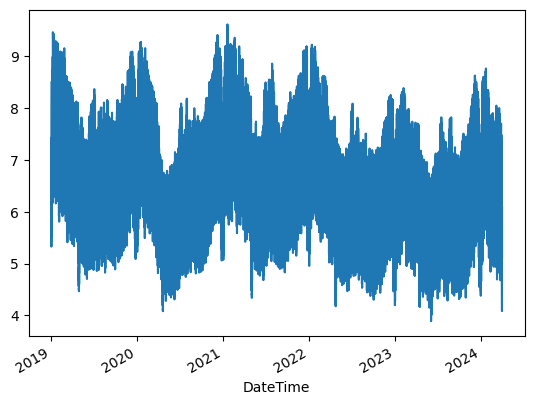

In [15]:
elec = df['Consumption']/1000 # All values devided by 1000 to normalize the data since our the data is quite big
elec.plot() # Plot the dataset

In [16]:
# We are going to create a matrix like bellow :
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []

  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [17]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(elec, WINDOW_SIZE)
X1.shape, y1.shape

((46006, 5, 1), (46006,))

In [18]:
# This is to devide the dataset into train, validation, and test set.

X_train1, y_train1 = X1[:37000], y1[:37000]
X_val1, y_val1 = X1[37000:40000], y1[37000:40000]
X_test1, y_test1 = X1[40000:], y1[40000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((37000, 5, 1), (37000,), (3000, 5, 1), (3000,), (6006, 5, 1), (6006,))

In [19]:
# Creating a LSTM model using tensorflow-keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Configuring the optimizer

cp1 = ModelCheckpoint('model1/model.keras', save_best_only=True) # Add '.keras' to the end of the filepath
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0384 - root_mean_squared_error: 0.1958 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2262
Epoch 2/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0373 - root_mean_squared_error: 0.1931 - val_loss: 0.0314 - val_root_mean_squared_error: 0.1771
Epoch 3/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0365 - root_mean_squared_error: 0.1911 - val_loss: 0.0332 - val_root_mean_squared_error: 0.1823
Epoch 4/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0368 - root_mean_squared_error: 0.1918 - val_loss: 0.0339 - val_root_mean_squared_error: 0.1842
Epoch 5/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0362 - root_mean_squared_error: 0.1903 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1691
Epoch 6/10
1157/1157 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0357 - root_mean_squared_error: 0.1888 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1890
Epoch 7/10
1157/1157 ━━━━━━━━━━━━━━━━━━

In [30]:
# To load trained model

from tensorflow.keras.models import load_model
model1 = load_model('model1/model.keras')

In [31]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train predictions':train_predictions, 'Actuals':y_train1})
train_results['Error'] = train_results['Actuals'] - train_results['Train predictions']
train_results['Percentage Error'] = (train_results['Error'] / train_results['Actuals']) * 100
train_results

1157/1157 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


,Train predictions,Actuals,Error,Percentage Error
0,5.531290,5.525,-0.006290,-0.113847
1,5.592702,5.513,-0.079702,-1.445717
2,5.629115,5.524,-0.105115,-1.902880
3,5.670575,5.510,-0.160575,-2.914249
4,5.628447,5.617,-0.011447,-0.203785
...,...,...,...,...
36995,6.888970,6.731,-0.157970,-2.346908
36996,6.592967,6.689,0.096033,1.435692
36997,6.704492,6.648,-0.056492,-0.849754
36998,6.670678,6.643,-0.027678,-0.416644


In [32]:
avg_error = train_results['Error'].mean()
max_error = train_results['Error'].max()
min_error = train_results['Error'].min()

print(f"Average Error: {avg_error}")
print(f"Maximum Error: {max_error}")
print(f"Minimum Error: {min_error}")

Average Error: 0.006848620246062408
Maximum Error: 1.4980787353515623
Minimum Error: -1.1447933235168453


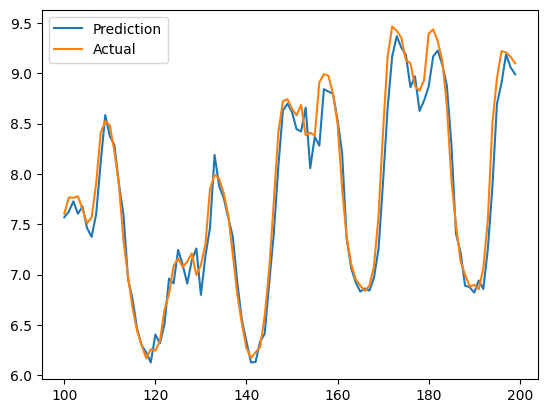

In [33]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train predictions'][100:200], label='Prediction') # Changed 'Train Predictions' to 'Train Predicted'
plt.plot(train_results['Actuals'][100:200], label='Actual') # Changed 'Actuals' to 'Train Actual'
plt.legend()

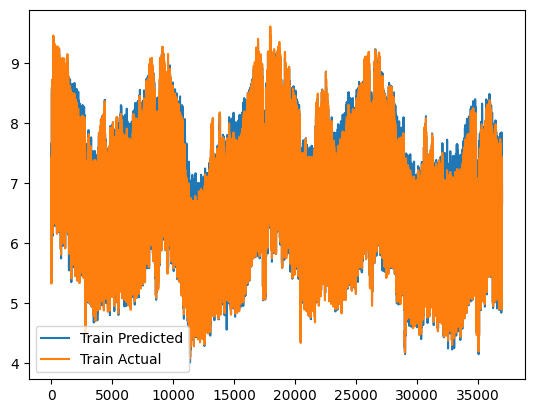

In [34]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train predictions'], label='Train Predicted')
plt.plot(train_results['Actuals'], label='Train Actual')
plt.legend()